# SAT Optics Simulation: Far-Field

This notebook models the far-field beam of the Small Aperture Telescope.  We use the near-field beam simulated in the $\verb|sat_holography|$ notebook and the fourier relationship between near- and far-fields to propagate this beam into the far-field. 

Grace E. Chesmore
March 2022

### Read in the near-field beam


  0%|          | 0/22500 [00:00<?, ?it/s]/home/chesmore/.local/lib/python3.8/site-packages/sosat_optics/ot_geo.py:65: RuntimeWarning: invalid value encountered in sqrt
  amp = (c * r ** 2) / (1 + np.sqrt(1 - ((1 + k) * c ** 2 * r ** 2)))
/home/chesmore/.local/lib/python3.8/site-packages/sosat_optics/ot_geo.py:107: RuntimeWarning: invalid value encountered in sqrt
  coeff_2 = (c * 2) / (1 + np.sqrt(1 - ((1 + k) * c ** 2 * r ** 2)))
/home/chesmore/.local/lib/python3.8/site-packages/sosat_optics/ot_geo.py:109: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1 - ((1 + k) * c ** 2 * r ** 2))
/home/chesmore/.local/lib/python3.8/site-packages/sosat_optics/ot_geo.py:110: RuntimeWarning: invalid value encountered in sqrt
  * (1 + np.sqrt(1 - ((1 + k) * c ** 2 * r ** 2))) ** 2
/home/chesmore/.local/lib/python3.8/site-packages/sosat_optics/ray_trace.py:14: RuntimeWarning: invalid value encountered in sqrt
  s2 = (n1 / n2) * np.cross(N_surf, (np.cross(-N_surf, s1))) - N_surf * np.sqrt(

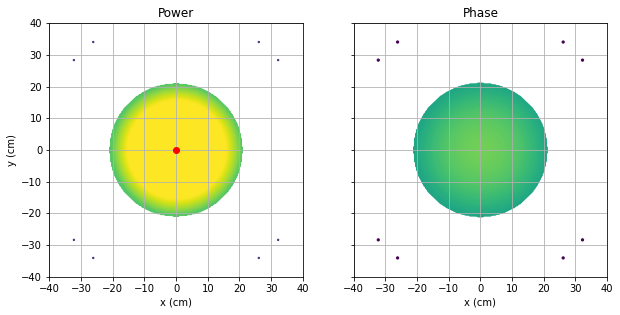

In [1]:
import numpy as np
import matplotlib
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
from scipy import interpolate

%matplotlib inline

import sosat_optics
from sosat_optics import ot_geo, opt_analyze,ray_trace

# Load in telescope geometry
tele_geo = ot_geo.SatGeo()
tele_geo.n_scan = 150  # sample number in 1D of 2D grid
tele_geo.y_source = (
    ot_geo.y_lyot + 300
)  # distance of holography source from SAT focal plane.
# tele_geo.lambda_ = 0.002  # wavelength of source, here we choose 150GHz.
tele_geo.lambda_ = 0.0023
tele_geo.k = 2 * np.pi / tele_geo.lambda_  # update kappa

rx = [0,0,0]  # receiver feed position in focal plane [mm]
# x_sim, y_sim, a_sim, p_sim = ray_trace.rx_to_lyot_OLD(rx, tele_geo, 0, "b")
out = ray_trace.rx_to_lyot(rx, tele_geo, 0, "b")
xx = np.where(out[4] != 0)
p_sim = np.mod(tele_geo.k * (out[3] - np.mean(out[3][xx])) / 1e3 / 2, 2 * np.pi)

fig,ax = plt.subplots(1,2,figsize=(10, 5),sharey=True)

ax[1].set_title("Phase")
ax[1].scatter(out[0][xx]/1e1, out[2][xx]/1e1, s=5, c=p_sim[xx])
ax[1].set_aspect("equal")
ax[1].set_xlim(-40, 40)
ax[1].set_ylim(-40, 40)
ax[1].set_xlabel("x (cm)")
ax[1].grid()

ax[0].set_title("Power")
ax[0].plot(0,0,'o',color = 'r')
ax[0].scatter(out[0][xx]/1e1, out[2][xx]/1e1, s=2, c=20*np.log10(out[4][xx]/np.max(out[4][xx])),vmax=-5,vmin=-20)
ax[0].set_aspect("equal")
ax[0].set_xlim(-40, 40)
ax[0].set_ylim(-40, 40)
ax[0].set_xlabel("x (cm)")
ax[0].set_ylabel("y (cm)")
ax[0].grid()
plt.show()

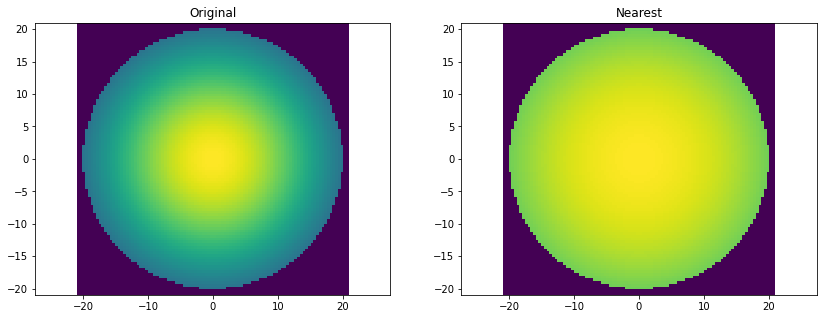

In [2]:
# # len_sim = int(np.sqrt(len(out[0])))
x_sim = out[0][xx]  # [mm]
y_sim = out[2][xx]  # [mm]

beam_cent = [np.mean(out[0][xx]), np.mean(out[2][xx])] # [mm]
indx_xy = np.where((np.isnan(x_sim) == False) & (np.isnan(y_sim) == False) & ((x_sim - beam_cent[0])**2 + (y_sim - beam_cent[1])**2 <= 210**2))

grid_x, grid_y = np.mgrid[np.min(x_sim[indx_xy])/1e1:np.max(x_sim[indx_xy])/1e1:100j, np.min(y_sim[indx_xy])/1e1:np.max(y_sim[indx_xy])/1e1:100j]
points = np.array([x_sim[indx_xy]/1e1, y_sim[indx_xy]/1e1]).T
values = np.array(p_sim[xx][indx_xy]).T # func(points[:,0], points[:,1])
from scipy.interpolate import griddata
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')
grid_z2 = np.where(((grid_x - (beam_cent[0]/1e1))**2 + (grid_y - (beam_cent[1]/1e1))**2 >= 20**2), 0, grid_z2)
grid_z2 = np.where(np.isnan(grid_z2), 0, grid_z2)
values = np.array(out[4][xx][indx_xy]).T 
grid_amp = griddata(points, values, (grid_x, grid_y), method='cubic')
grid_amp = np.where(((grid_x - (beam_cent[0]/1e1))**2 + (grid_y - (beam_cent[1]/1e1))**2 >= 20**2), 0, grid_amp)
grid_amp = np.where(np.isnan(grid_amp), 0, grid_amp)

import matplotlib.pyplot as plt
plt.figure(figsize = (14,5))
plt.subplot(121)
plt.pcolormesh(grid_x,grid_y,(grid_amp),shading = 'auto')
plt.axis("equal")
plt.title('Original')
plt.subplot(122)
plt.pcolormesh(grid_x,grid_y,np.mod(grid_z2,2*np.pi),shading = 'auto')
plt.axis("equal")
plt.title('Nearest')
plt.show()



## Propagating Aperture-field into the Far-field

Now that we have our near-fields $b(x,y)$ above the SAT window, we want to propagate the fields into the far-field $B(\theta,\phi)$ using the relation:

$$ B(\theta,\phi) = \int_{aperture} b(x,y)e^{i2\pi(x\theta + y\phi)} dx dy$$

where we integrate over the aperture, which is the window of the SAT.

In [ ]:
# Zero padding: to increase the resolution of our far-field
# we zero-pad the aperture fields before propagating.  Set
# the number of pixels to pad to the array.

# def zero_pad(x_in, y_in, beam_in, pts):
#     x_int = abs(x_in[0, 0] - x_in[1, 1])
#     y_int = abs(y_in[0, 0] - y_in[1, 1])
#     beam_out = np.pad(beam_in, pts, mode="constant")
#     x_new = np.array(np.arange(len(beam_out)))
#     y_new = np.array(np.arange(len(beam_out)))
#     x_new = x_new * x_int
#     y_new = y_new * y_int
#     x_new -= np.mean(x_new)
#     y_new -= np.mean(y_new)
#     x_new, y_new = np.meshgrid(x_new, y_new)
#     beam_out = np.where(np.isnan(beam_out)==True, 0, beam_out)
#     return x_new + np.mean(x_in), y_new + np.mean(y_in), beam_out.T

# pix_num = 100

# x = grid_x
# y = grid_y

# beam_conv = grid_amp * np.exp(complex(0,1)* grid_z2)

# x_new, y_new, beam_final = zero_pad(x, y, beam_conv, pix_num)

# plt.figure(figsize=(6, 5))
# plt.pcolormesh(x_new, y_new, abs(beam_final)/np.max(abs(beam_final)), shading="auto")
# plt.colorbar()
# plt.xlabel("x [cm]")
# plt.ylabel("y [cm]")
# plt.title("Near-field of SAT")
# plt.axis("equal")
# plt.show()

# plt.figure(figsize=(6, 5))
# plt.pcolormesh(x_new, y_new, np.arctan2(np.imag(beam_final), np.real(beam_final)))
# plt.colorbar()
# plt.xlabel("x [cm]")
# plt.ylabel("y [cm]")
# plt.title("Near-field of SAT")
# plt.axis("equal")
# plt.show()


<ipython-input-3-d63f89c15816>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_data, y_data, np.abs(beam_data)/np.max(np.abs(beam_data)))


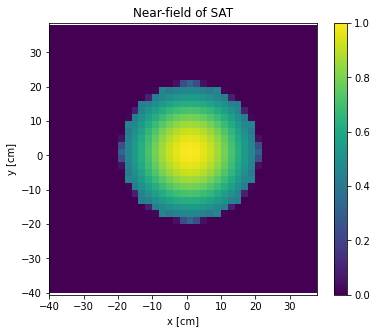

<ipython-input-3-d63f89c15816>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_data, y_data, phase_data)


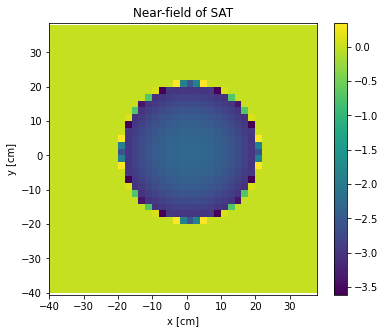

In [3]:
beam_final = grid_amp.T * np.exp(complex(0,1)* grid_z2.T)

STAGE_RANGE = 80 # [cm]
STEP = 2 # [cm]
# Interpolate to new 2D grid    
# x_interp = x_new[0, :]
# y_interp = y_new[:, 0]
x_interp = grid_x[:, 0]
y_interp = grid_y[0, :]
func_beam = interpolate.interp2d(x_interp, y_interp, np.abs(beam_final)/np.max(np.abs(beam_final)), kind='cubic')
func_phase = interpolate.interp2d(x_interp, y_interp, np.arctan2(np.imag(beam_final), np.real(beam_final)), kind='cubic')
x_data = np.arange(-STAGE_RANGE/2, STAGE_RANGE/2, STEP)
y_data = np.arange(-STAGE_RANGE/2, STAGE_RANGE/2, STEP)
beam_data = func_beam(x_data, y_data)
phase_data = func_phase(x_data, y_data)

x_data,y_data = np.meshgrid(x_data,y_data)
plt.figure(figsize=(6, 5))
plt.pcolormesh(x_data, y_data, np.abs(beam_data)/np.max(np.abs(beam_data)))
plt.colorbar()
plt.xlabel("x [cm]")
plt.ylabel("y [cm]")
plt.title("Near-field of SAT")
plt.axis("equal")
plt.show()

plt.figure(figsize=(6, 5))
plt.pcolormesh(x_data, y_data, phase_data)
plt.colorbar()
plt.xlabel("x [cm]")
plt.ylabel("y [cm]")
plt.title("Near-field of SAT")
plt.axis("equal")
plt.show()


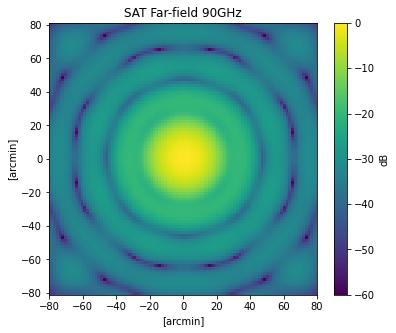

In [4]:
pix_num = 100

x_new, y_new, beam_data = opt_analyze.zero_pad(x_data, y_data, beam_data, pix_num)
x_data, y_data, phase_data = opt_analyze.zero_pad(x_data, y_data, phase_data, pix_num)

# phase = np.arctan2(np.imag(beam_data), np.real(beam_data))
beam_fft, phase_fft = opt_analyze.a2b(beam_data, np.rad2deg(phase_data))

x_ang, y_ang = opt_analyze.coords_spat_to_ang(
    x_data / 1e2, y_data / 1e2, opt_analyze.m_to_ghz(tele_geo.lambda_)
)

plt.figure(figsize=(6, 5))
plt.title("SAT Far-field 90GHz")
plt.pcolormesh(
    x_ang * 180 * 60 / np.pi,
    y_ang * 180 * 60 / np.pi,
    20 * np.log10(abs(beam_fft) / np.max(abs(beam_fft))),
    vmin=-60,
    shading="auto",
)
plt.xlabel("[arcmin]")
plt.ylabel("[arcmin]")
plt.colorbar(label="dB")
plt.axis("equal")
plt.xlim(-80, 80)
plt.ylim(-80, 80)
plt.show()

In [6]:
abs(x_ang[0,0] -  x_ang[0,1])*180*60/np.pi

1.654145935733351

## Predicted Beam Size
Our simulated beam size determines the resolution of our telescope.  We can compare this to the beam size of an Airy disc with aperture $D$ at wavelength $\lambda$:

$$\theta_{FWHM} = 1.025 \frac{\lambda}{D} $$

In [7]:
a = abs(beam_fft) ** 2 / np.max(abs(beam_fft) ** 2)
x_out = y_ang
y_out = x_ang

indx = np.where(abs(a) == np.max(abs(a)))
x = y_out[indx[0][0], :] * 60 * 180 / np.pi
y = abs(a)[indx[0][0], :] / np.max(abs(a))
v1 = x[np.where((y > 0.5))][0]
v2 = x[np.where((y > 0.5))][-1]

fwhm1 = abs(v1 - v2)

indx = np.where(abs(a) == np.max(abs(a)))
x = x_out[:, indx[1][0]] * 60 * 180 / np.pi
y = abs(a)[:, indx[1][0]] / np.max(abs(a))
v1 = x[np.where((y > 0.5))][0]
v2 = x[np.where((y > 0.5))][-1]

fwhm2 = abs(v1 - v2)
fwhm = (fwhm1 + fwhm2) / 2
print(f"Simulated beam size: {fwhm:.2f} arcmin.")
print(
    f"Predicted beam size: {opt_analyze.rad_to_arcmin((1.025*tele_geo.lambda_ /tele_geo.diam)):.2f} arcmin."
)

Simulated beam size: 19.85 arcmin.
Predicted beam size: 19.30 arcmin.


### Now for multiple frequencies:

In [10]:
freq_arr = [85, 90, 95, 102, 106, 110, 115, 130, 135, 140]

for ii,freq in enumerate(freq_arr):

    tele_geo.n_scan = 100
    tele_geo.lambda_ = opt_analyze.ghz_to_m(freq)
    tele_geo.k = 2 * np.pi / tele_geo.lambda_  # update kappa

    rx = [0,0,0]  # receiver feed position in focal plane [mm]
    out = ray_trace.rx_to_lyot(rx, tele_geo, 0, "b")
    xx = np.where(out[4] != 0)
    p_sim = np.mod(tele_geo.k * (out[3] - np.mean(out[3][xx])) / 1e3 / 2, 2 * np.pi)

    x_sim = out[0][xx]  # [mm]
    y_sim = out[2][xx]  # [mm]

    beam_cent = [np.mean(out[0][xx]), np.mean(out[2][xx])] # [mm]
    indx_xy = np.where((np.isnan(x_sim) == False) & (np.isnan(y_sim) == False) & ((x_sim - beam_cent[0])**2 + (y_sim - beam_cent[1])**2 <= 210**2))

    grid_x, grid_y = np.mgrid[np.min(x_sim[indx_xy])/1e1:np.max(x_sim[indx_xy])/1e1:100j, np.min(y_sim[indx_xy])/1e1:np.max(y_sim[indx_xy])/1e1:100j]
    points = np.array([x_sim[indx_xy]/1e1, y_sim[indx_xy]/1e1]).T
    values = np.array(p_sim[xx][indx_xy]).T # func(points[:,0], points[:,1])
    from scipy.interpolate import griddata
    grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')
    grid_z2 = np.where(((grid_x - (beam_cent[0]/1e1))**2 + (grid_y - (beam_cent[1]/1e1))**2 >= 20**2), 0, grid_z2)
    grid_z2 = np.where(np.isnan(grid_z2), 0, grid_z2)
    values = np.array(out[4][xx][indx_xy]).T 
    grid_amp = griddata(points, values, (grid_x, grid_y), method='cubic')
    grid_amp = np.where(((grid_x - (beam_cent[0]/1e1))**2 + (grid_y - (beam_cent[1]/1e1))**2 >= 20**2), 0, grid_amp)
    grid_amp = np.where(np.isnan(grid_amp), 0, grid_amp)

    beam_final = grid_amp.T * np.exp(complex(0,1)* grid_z2.T)

    STAGE_RANGE = 80 # [cm]
    STEP = 2 # [cm]
    # Interpolate to new 2D grid    
    # x_interp = x_new[0, :]
    # y_interp = y_new[:, 0]
    x_interp = grid_x[:, 0]
    y_interp = grid_y[0, :]
    func_beam = interpolate.interp2d(x_interp, y_interp, np.abs(beam_final)/np.max(np.abs(beam_final)), kind='cubic')
    func_phase = interpolate.interp2d(x_interp, y_interp, np.arctan2(np.imag(beam_final), np.real(beam_final)), kind='cubic')
    x_data = np.arange(-STAGE_RANGE/2, STAGE_RANGE/2, STEP)
    y_data = np.arange(-STAGE_RANGE/2, STAGE_RANGE/2, STEP)
    beam_data = func_beam(x_data, y_data)
    phase_data = func_phase(x_data, y_data)

    x_data,y_data = np.meshgrid(x_data,y_data)

    pix_num = 100

    x_new, y_new, beam_data = opt_analyze.zero_pad(x_data, y_data, beam_data, pix_num)
    x_data, y_data, phase_data = opt_analyze.zero_pad(x_data, y_data, phase_data, pix_num)

    # phase = np.arctan2(np.imag(beam_data), np.real(beam_data))
    beam_fft, phase_fft = opt_analyze.a2b(beam_data, np.rad2deg(phase_data))

    x_ang, y_ang = opt_analyze.coords_spat_to_ang(
        x_data / 1e2, y_data / 1e2, opt_analyze.m_to_ghz(tele_geo.lambda_)
    )
    a = abs(beam_fft) ** 2 / np.max(abs(beam_fft) ** 2)
    x_out = y_ang
    y_out = x_ang

    indx = np.where(abs(a) == np.max(abs(a)))
    x = y_out[indx[0][0], :] * 60 * 180 / np.pi
    y = abs(a)[indx[0][0], :] / np.max(abs(a))
    v1 = x[np.where((y > 0.5))][0]
    v2 = x[np.where((y > 0.5))][-1]

    fwhm1 = abs(v1 - v2)

    indx = np.where(abs(a) == np.max(abs(a)))
    x = x_out[:, indx[1][0]] * 60 * 180 / np.pi
    y = abs(a)[:, indx[1][0]] / np.max(abs(a))
    v1 = x[np.where((y > 0.5))][0]
    v2 = x[np.where((y > 0.5))][-1]

    fwhm2 = abs(v1 - v2)
    fwhm = (fwhm1 + fwhm2) / 2

    print(f"Simulated beam size: {fwhm:.2f} arcmin.")

100%|██████████| 10000/10000 [00:15<00:00, 647.89it/s]


Simulated beam size: 30.46 arcmin.


100%|██████████| 10000/10000 [00:14<00:00, 684.68it/s]



Simulated beam size: 28.77 arcmin.


100%|██████████| 10000/10000 [00:14<00:00, 670.28it/s]


Simulated beam size: 27.25 arcmin.


100%|██████████| 10000/10000 [00:14<00:00, 667.80it/s]


Simulated beam size: 25.38 arcmin.


100%|██████████| 10000/10000 [00:14<00:00, 666.93it/s]


Simulated beam size: 24.43 arcmin.


100%|██████████| 10000/10000 [00:15<00:00, 664.99it/s]


Simulated beam size: 23.54 arcmin.


100%|██████████| 10000/10000 [00:15<00:00, 666.18it/s]


Simulated beam size: 22.51 arcmin.


100%|██████████| 10000/10000 [00:14<00:00, 667.01it/s]



Simulated beam size: 19.92 arcmin.


100%|██████████| 10000/10000 [00:14<00:00, 687.06it/s]



Simulated beam size: 19.18 arcmin.


100%|██████████| 10000/10000 [00:14<00:00, 703.29it/s]


Simulated beam size: 18.49 arcmin.
